In [2]:
import os
import pandas as pd
import numpy as np
from scipy.sparse import load_npz
import sys
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import math
from scipy.stats import norm
from healthrex_ml.evaluators import BinaryEvaluator
from tqdm import tqdm

In [3]:
from ngboost import NGBRegressor
from functions.trainers import NGBoostTrainer, LightGBMTrainer

In [4]:
trainer = NGBoostTrainer(working_dir="/deep/group/aihc/win23/EHR/20230218_jyx_mcp_artifacts")

In [5]:
tasks = ['label_NA', 'label_K', 'label_CR', 'label_CA', 'label_ALB']

In [5]:
for task in tasks:
    trainer(task)

[iter 0] loss=2.9165 val_loss=0.0000 scale=1.0000 norm=3.4134
[iter 20] loss=2.8240 val_loss=0.0000 scale=1.0000 norm=3.2103
[iter 40] loss=2.7683 val_loss=0.0000 scale=1.0000 norm=3.0701
[iter 60] loss=2.7284 val_loss=0.0000 scale=1.0000 norm=2.9689
[iter 80] loss=2.6960 val_loss=0.0000 scale=1.0000 norm=2.8927
[iter 100] loss=2.6713 val_loss=0.0000 scale=1.0000 norm=2.8401
[iter 120] loss=2.6509 val_loss=0.0000 scale=1.0000 norm=2.7999
[iter 140] loss=2.6322 val_loss=0.0000 scale=1.0000 norm=2.7660
[iter 160] loss=2.6179 val_loss=0.0000 scale=1.0000 norm=2.7423
[iter 180] loss=2.6065 val_loss=0.0000 scale=1.0000 norm=2.7247
[iter 200] loss=2.5972 val_loss=0.0000 scale=1.0000 norm=2.7112
[iter 220] loss=2.5893 val_loss=0.0000 scale=1.0000 norm=2.7005
[iter 240] loss=2.5828 val_loss=0.0000 scale=1.0000 norm=2.6916
[iter 260] loss=2.5772 val_loss=0.0000 scale=1.0000 norm=2.6841
[iter 280] loss=2.5726 val_loss=0.0000 scale=1.0000 norm=2.6779
[iter 300] loss=2.5688 val_loss=0.0000 scale=1

/deep/u/andleerew/anaconda3/envs/healthrex/lib/python3.7/site-packages/ngboost/distns/normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
/deep/u/andleerew/anaconda3/envs/healthrex/lib/python3.7/site-packages/ngboost/distns/normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2


[iter 0] loss=0.9094 val_loss=0.0000 scale=0.0625 norm=0.0503
[iter 20] loss=0.6214 val_loss=0.0000 scale=2.0000 norm=1.1908
[iter 40] loss=0.4692 val_loss=0.0000 scale=1.0000 norm=0.5511
[iter 60] loss=0.3640 val_loss=0.0000 scale=1.0000 norm=0.5344
[iter 80] loss=0.2495 val_loss=0.0000 scale=2.0000 norm=1.0471
[iter 100] loss=0.1424 val_loss=0.0000 scale=2.0000 norm=1.0358
[iter 120] loss=0.0670 val_loss=0.0000 scale=2.0000 norm=1.0321
[iter 140] loss=-0.0039 val_loss=0.0000 scale=2.0000 norm=1.0333
[iter 160] loss=-0.0581 val_loss=0.0000 scale=2.0000 norm=1.0393
[iter 180] loss=-0.1039 val_loss=0.0000 scale=2.0000 norm=1.0489
[iter 200] loss=-0.1399 val_loss=0.0000 scale=2.0000 norm=1.0585
[iter 220] loss=-0.1668 val_loss=0.0000 scale=2.0000 norm=1.0695


/deep/u/andleerew/anaconda3/envs/healthrex/lib/python3.7/site-packages/ngboost/distns/normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2


[iter 240] loss=-0.1855 val_loss=0.0000 scale=1.0000 norm=0.5388
[iter 260] loss=-0.1988 val_loss=0.0000 scale=2.0000 norm=1.0847
[iter 280] loss=-0.2087 val_loss=0.0000 scale=1.0000 norm=0.5458
[iter 300] loss=-0.2166 val_loss=0.0000 scale=1.0000 norm=0.5486
[iter 320] loss=-0.2243 val_loss=0.0000 scale=1.0000 norm=0.5512
[iter 340] loss=-0.2307 val_loss=0.0000 scale=1.0000 norm=0.5533
[iter 360] loss=-0.2357 val_loss=0.0000 scale=1.0000 norm=0.5550
[iter 380] loss=-0.2401 val_loss=0.0000 scale=1.0000 norm=0.5562
[iter 400] loss=-0.2444 val_loss=0.0000 scale=1.0000 norm=0.5572
[iter 420] loss=-0.2483 val_loss=0.0000 scale=1.0000 norm=0.5583
[iter 440] loss=-0.2519 val_loss=0.0000 scale=1.0000 norm=0.5588
[iter 460] loss=-0.2553 val_loss=0.0000 scale=1.0000 norm=0.5593
[iter 480] loss=-0.2583 val_loss=0.0000 scale=1.0000 norm=0.5597
label_CR MSE Loss: 0.1; NLL Loss: -0.15.


/deep/u/andleerew/anaconda3/envs/healthrex/lib/python3.7/site-packages/ngboost/distns/normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2


[iter 0] loss=1.1740 val_loss=0.0000 scale=1.0000 norm=0.8736
[iter 20] loss=1.0629 val_loss=0.0000 scale=1.0000 norm=0.7853
[iter 40] loss=1.0028 val_loss=0.0000 scale=1.0000 norm=0.7484
[iter 60] loss=0.9468 val_loss=0.0000 scale=1.0000 norm=0.7213
[iter 80] loss=0.9106 val_loss=0.0000 scale=2.0000 norm=1.4166
[iter 100] loss=0.8799 val_loss=0.0000 scale=2.0000 norm=1.4000
[iter 120] loss=0.8522 val_loss=0.0000 scale=1.0000 norm=0.6948
[iter 140] loss=0.8310 val_loss=0.0000 scale=1.0000 norm=0.6922
[iter 160] loss=0.8136 val_loss=0.0000 scale=1.0000 norm=0.6909
[iter 180] loss=0.7997 val_loss=0.0000 scale=1.0000 norm=0.6908
[iter 200] loss=0.7879 val_loss=0.0000 scale=1.0000 norm=0.6915
[iter 220] loss=0.7772 val_loss=0.0000 scale=1.0000 norm=0.6925
[iter 240] loss=0.7685 val_loss=0.0000 scale=1.0000 norm=0.6938
[iter 260] loss=0.7609 val_loss=0.0000 scale=1.0000 norm=0.6951
[iter 280] loss=0.7543 val_loss=0.0000 scale=1.0000 norm=0.6965
[iter 300] loss=0.7486 val_loss=0.0000 scale=1

In [8]:
working_dir = "/deep/group/aihc/win23/EHR/20230218_jyx_mcp_artifacts"
y_hats_NA = pd.read_csv(
            os.path.join(working_dir, 'label_NA_yhats.csv'))
y_hats_K = pd.read_csv(
            os.path.join(working_dir, 'label_K_yhats.csv'))
y_hats_CR = pd.read_csv(
            os.path.join(working_dir, 'label_CR_yhats.csv'))
y_hats_CA = pd.read_csv(
            os.path.join(working_dir, 'label_CA_yhats.csv'))
y_hats_ALB = pd.read_csv(
            os.path.join(working_dir, 'label_ALB_yhats.csv'))

In [9]:
y_test = pd.read_csv(
    os.path.join(working_dir, "test_labels.csv"))

In [10]:
def add_probs(df, test, delta):
    last_test = "label_last_" + test
    df["upper_z"] = (y_test[last_test] + delta - df["dist_mean"]) / np.sqrt(df["dist_var"])
    df["lower_z"] = (y_test[last_test] - delta - df["dist_mean"]) / np.sqrt(df["dist_var"])
    df["upper_p"] = 1 - norm.cdf(df["upper_z"])
    df["lower_p"] = norm.cdf(df["lower_z"])
    df["stable_p"] = 1 - df["upper_p"] - df["lower_p"]
    key_idx = ["observation_id", "dist_mean", "dist_var", "upper_p", "lower_p", "stable_p"]
    return df[key_idx]

In [11]:
py_hats_NA = add_probs(y_hats_NA, "NA", 2.5)
py_hats_K = add_probs(y_hats_K, "K", 0.5)
py_hats_CR = add_probs(y_hats_CR, "CR", 0.125)
py_hats_CA = add_probs(y_hats_CA, "CA", 0.525)
py_hats_ALB = add_probs(y_hats_ALB, "ALB", 0.425)

In [12]:
def add_truth_label(test, delta):
    label = "label_" + test
    last_test = "label_last_" + test
    stable = "label_" + test + "_stable"
    lower = "label_" + test + "_lower"
    higher = "label_" + test + "_higher"
    y_test[lower] = (y_test[last_test] - delta > y_test[label])
    y_test[higher] = (y_test[label] > y_test[last_test] + delta)
    y_test[stable] = (~y_test[lower]) & (~y_test[higher])

In [13]:
tests = ["NA", "K", "CR", "CA", "ALB"]
d = {
    "NA": 2.5,
    "K": 0.5,
    "CR": 0.125,
    "CA": 0.525,
    "ALB": 0.425
}
for test in tests:
    add_truth_label(test, d[test])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [1:06:29<00:00, 797.97s/it]


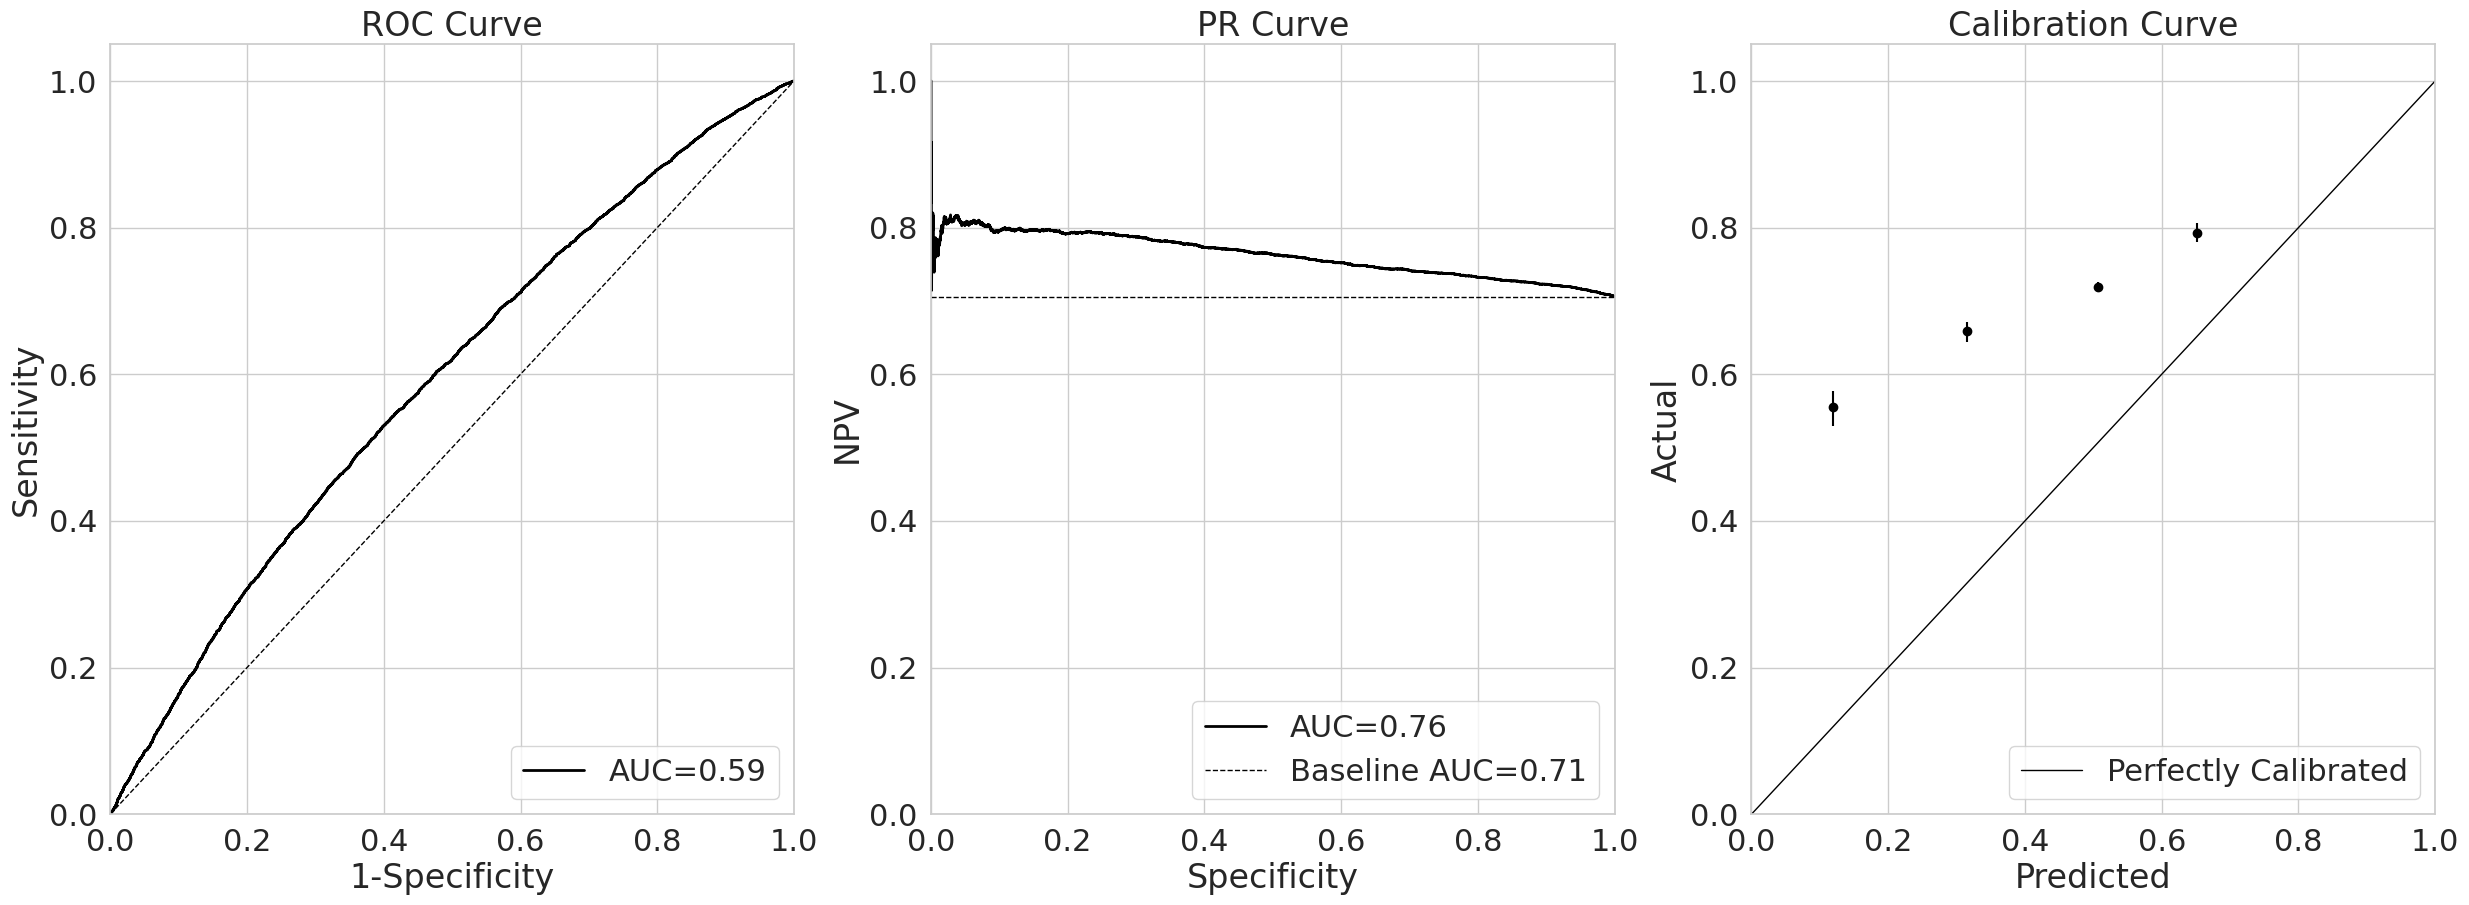

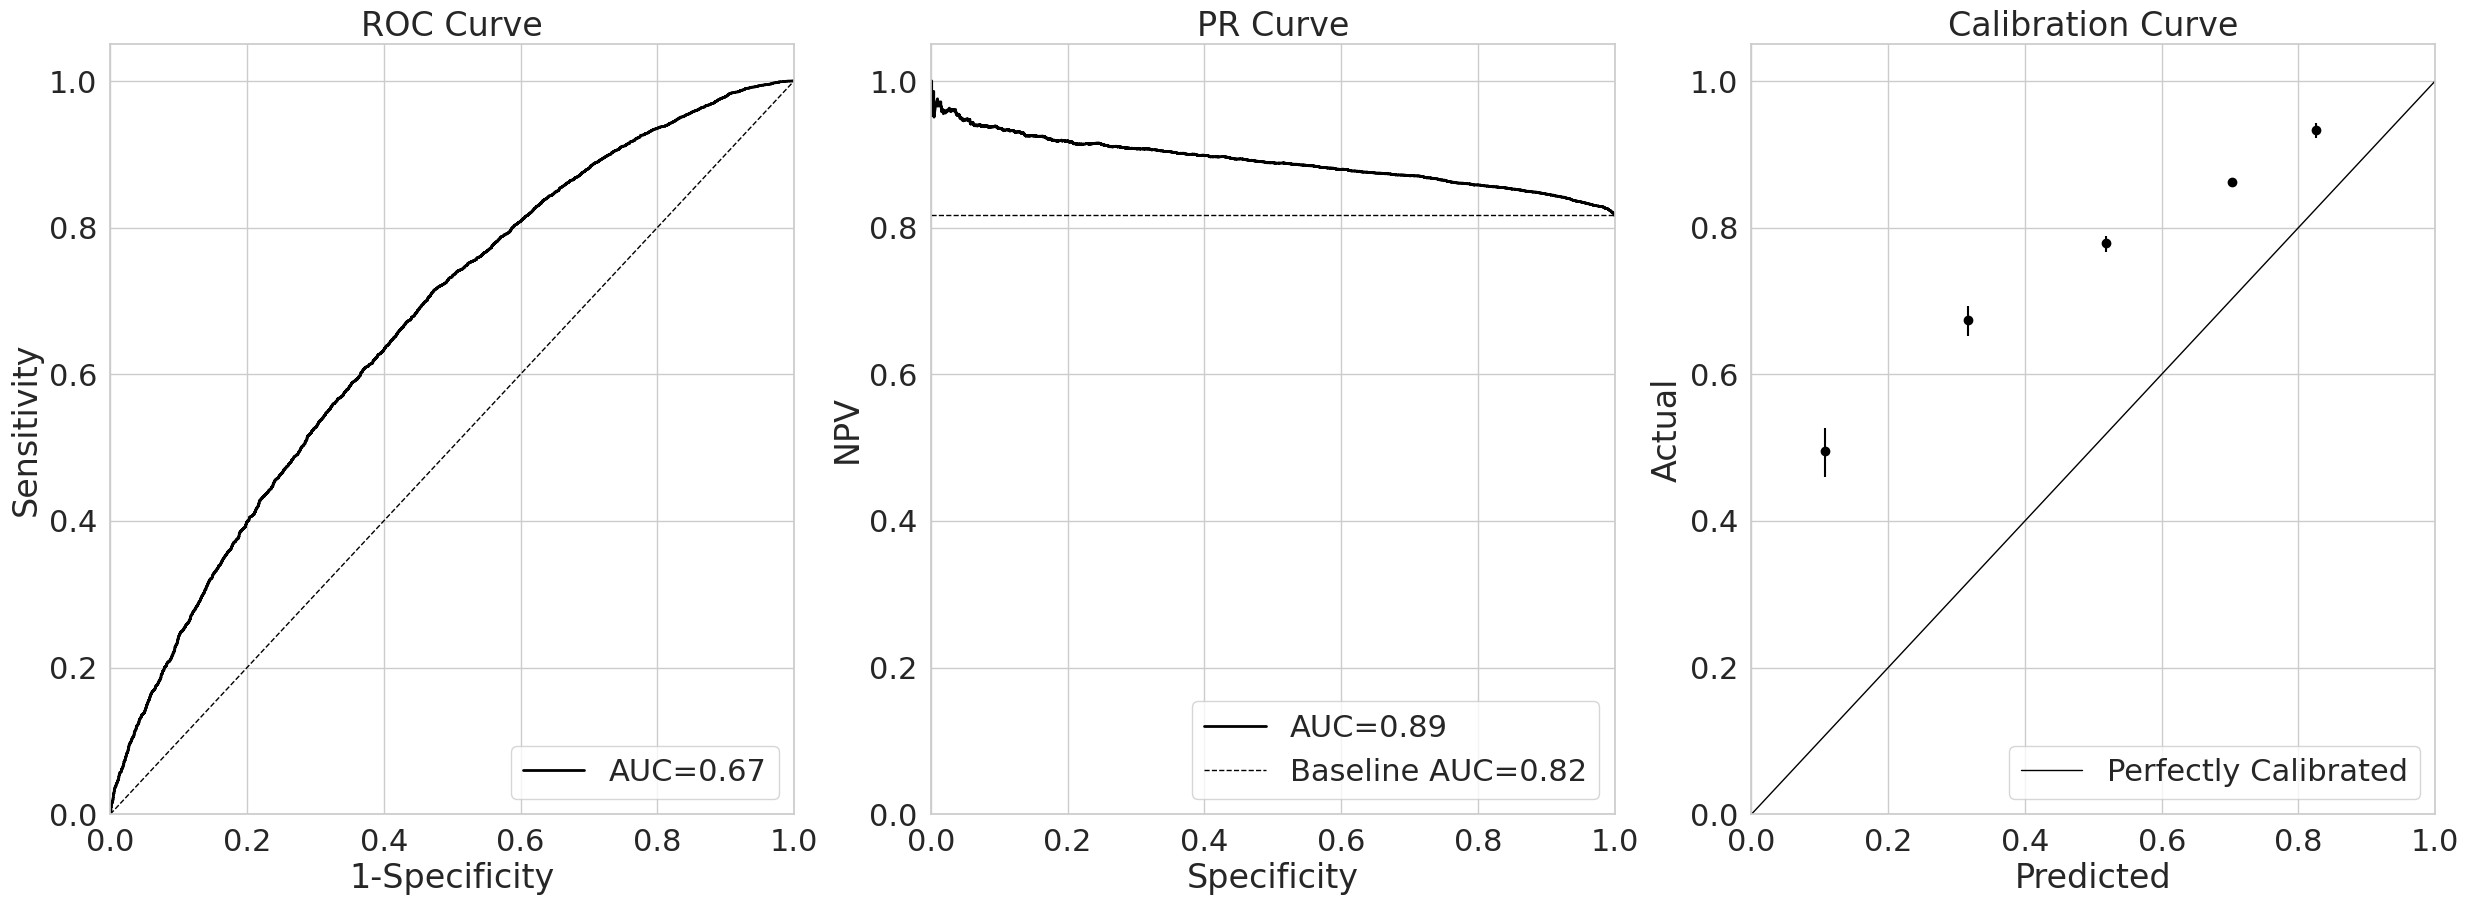

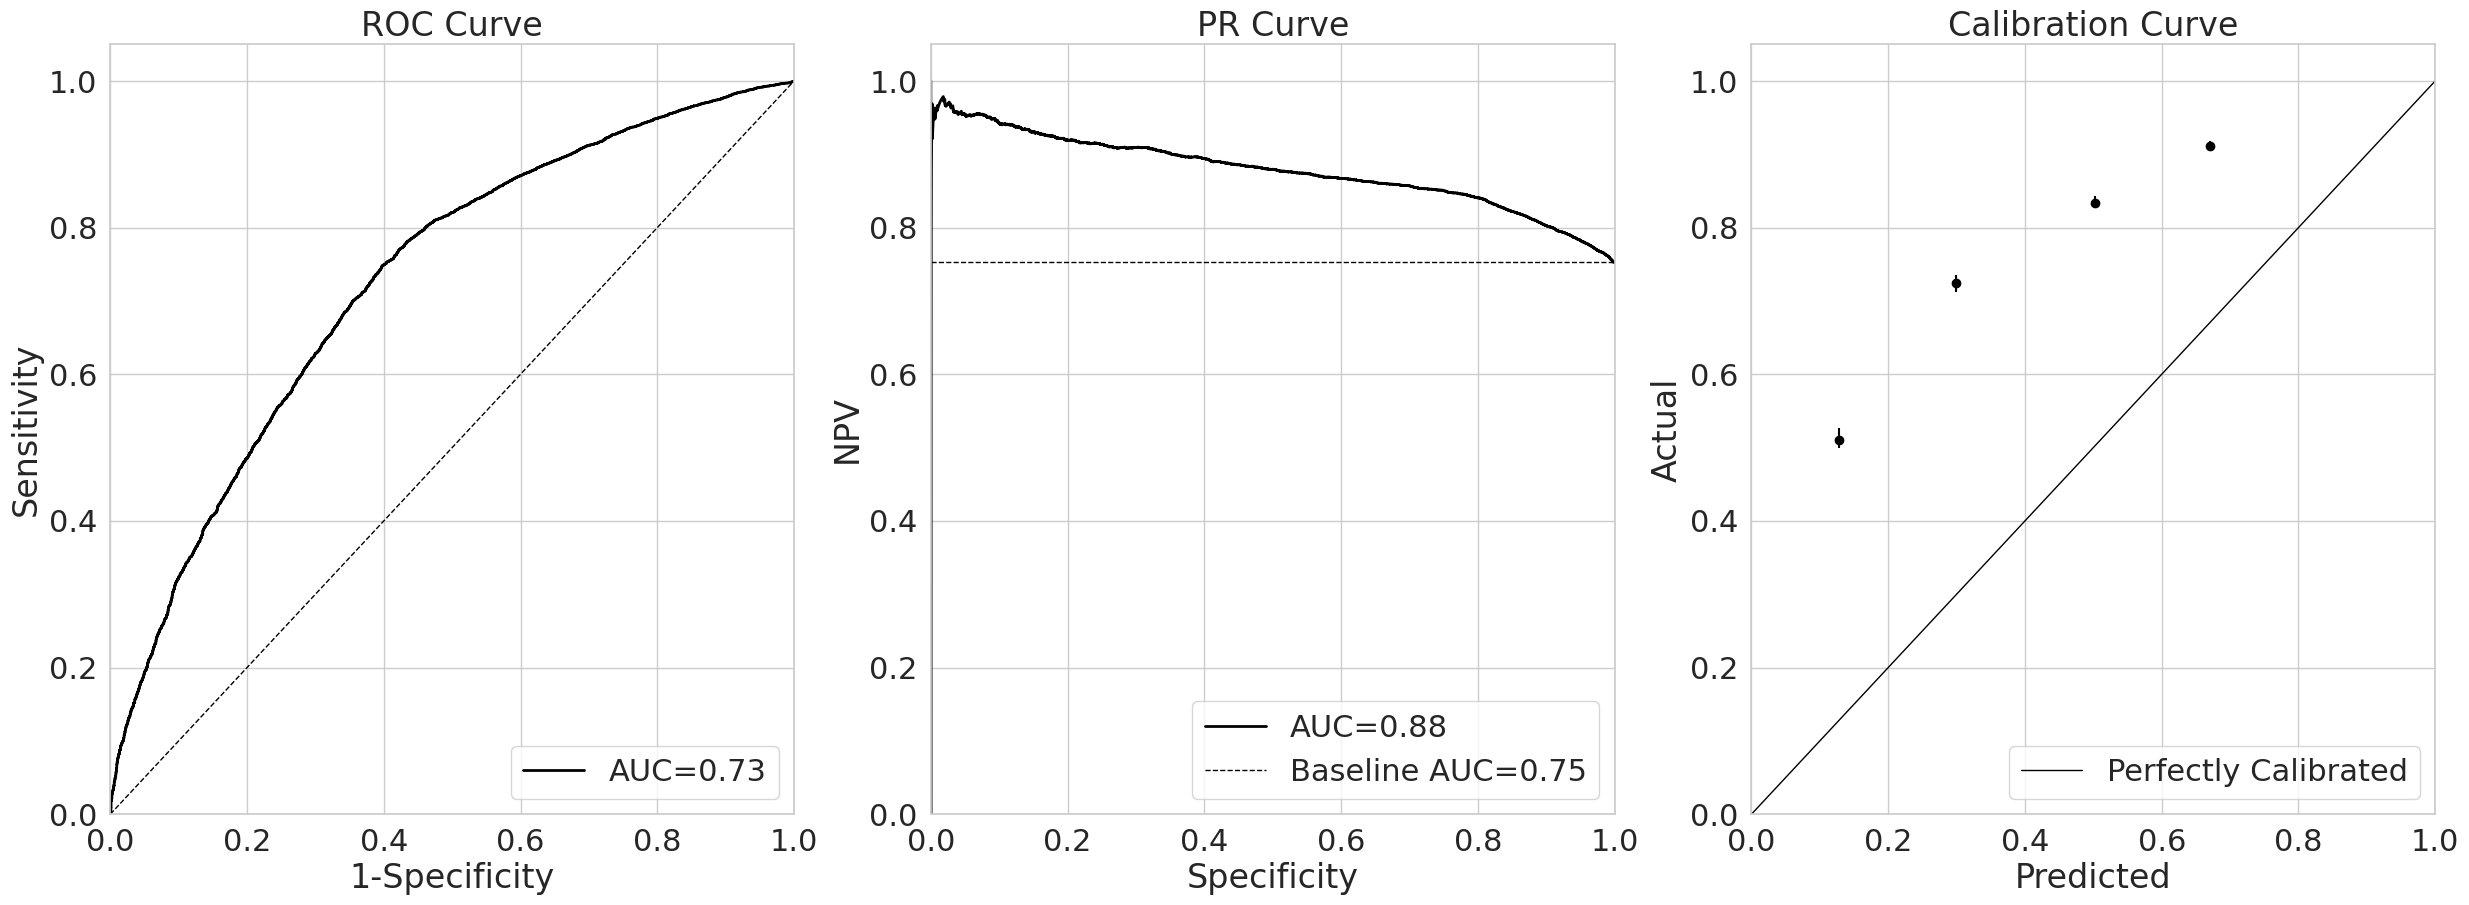

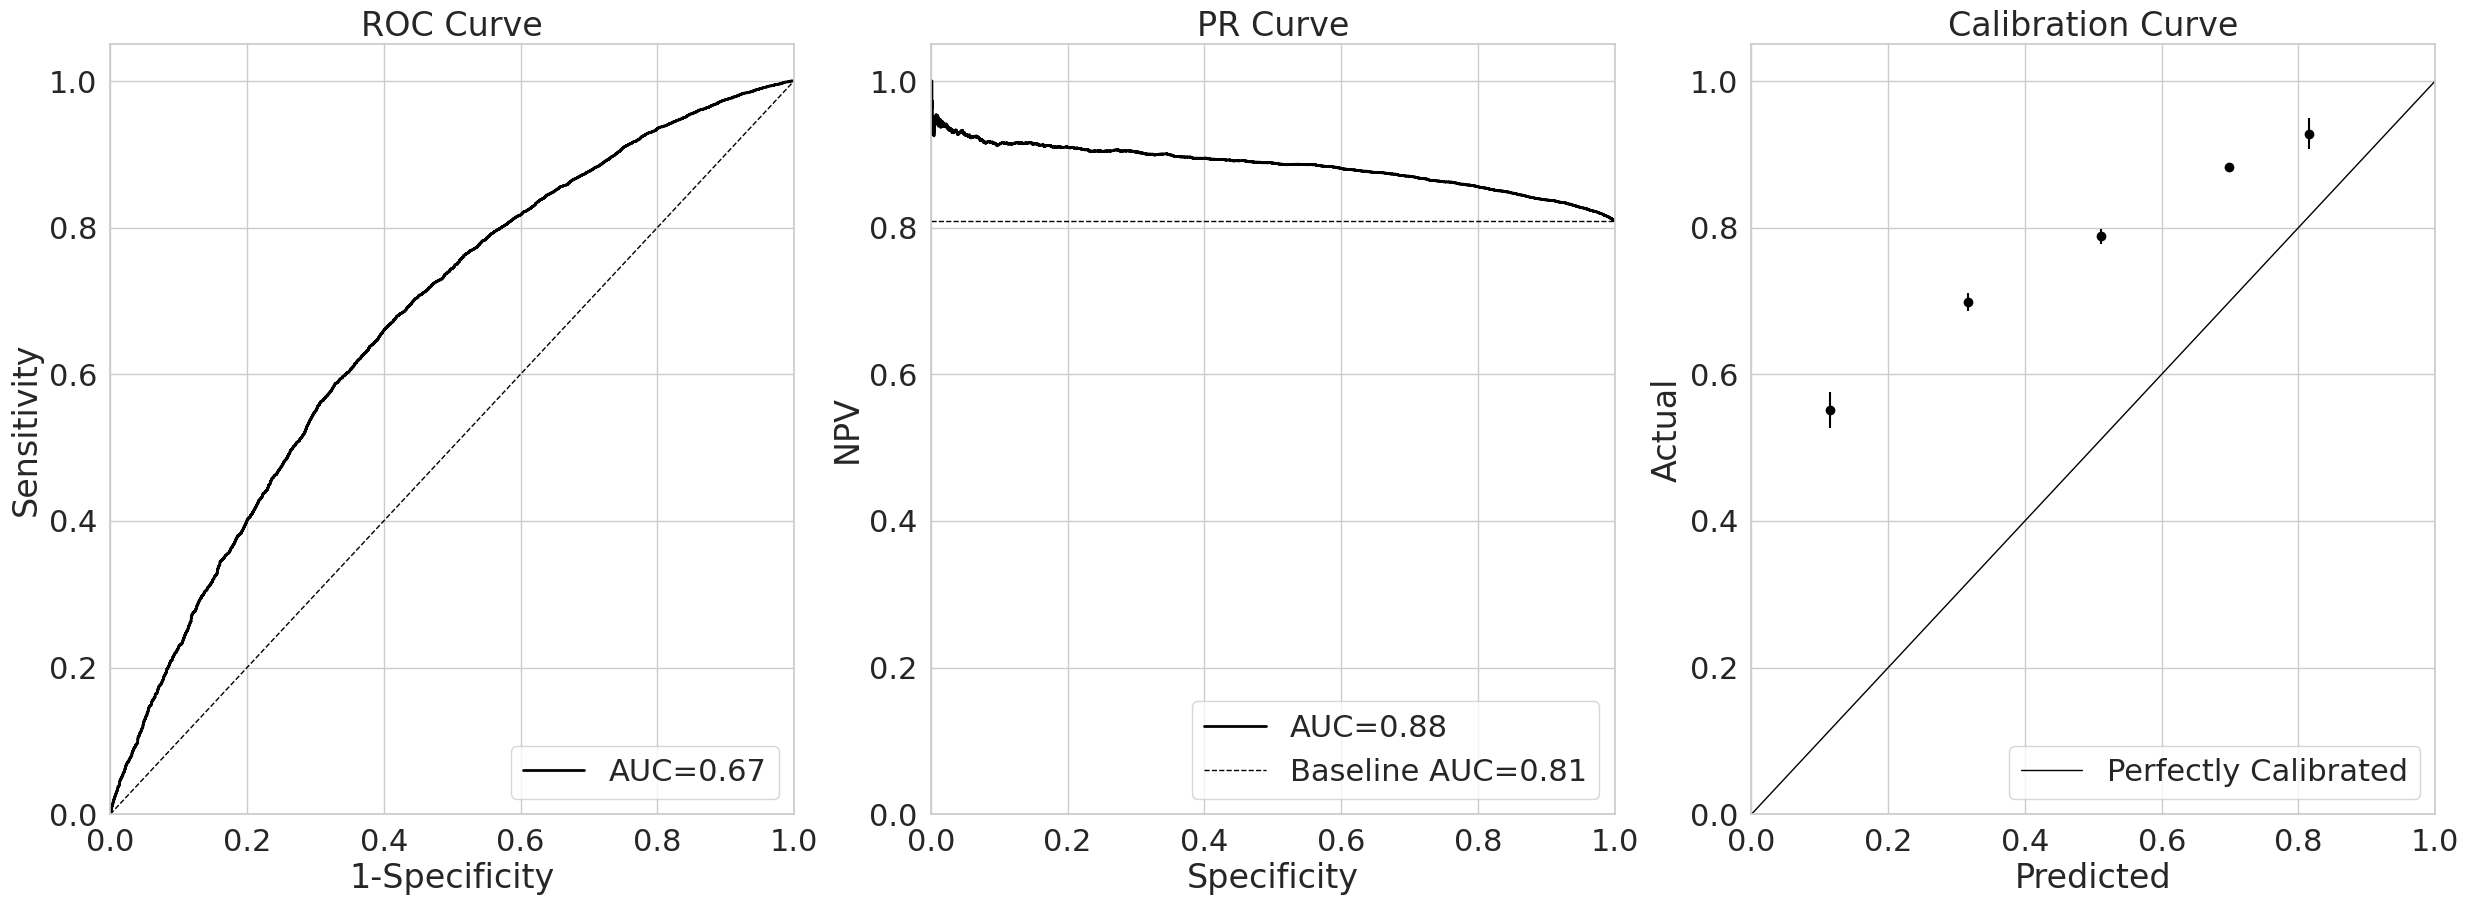

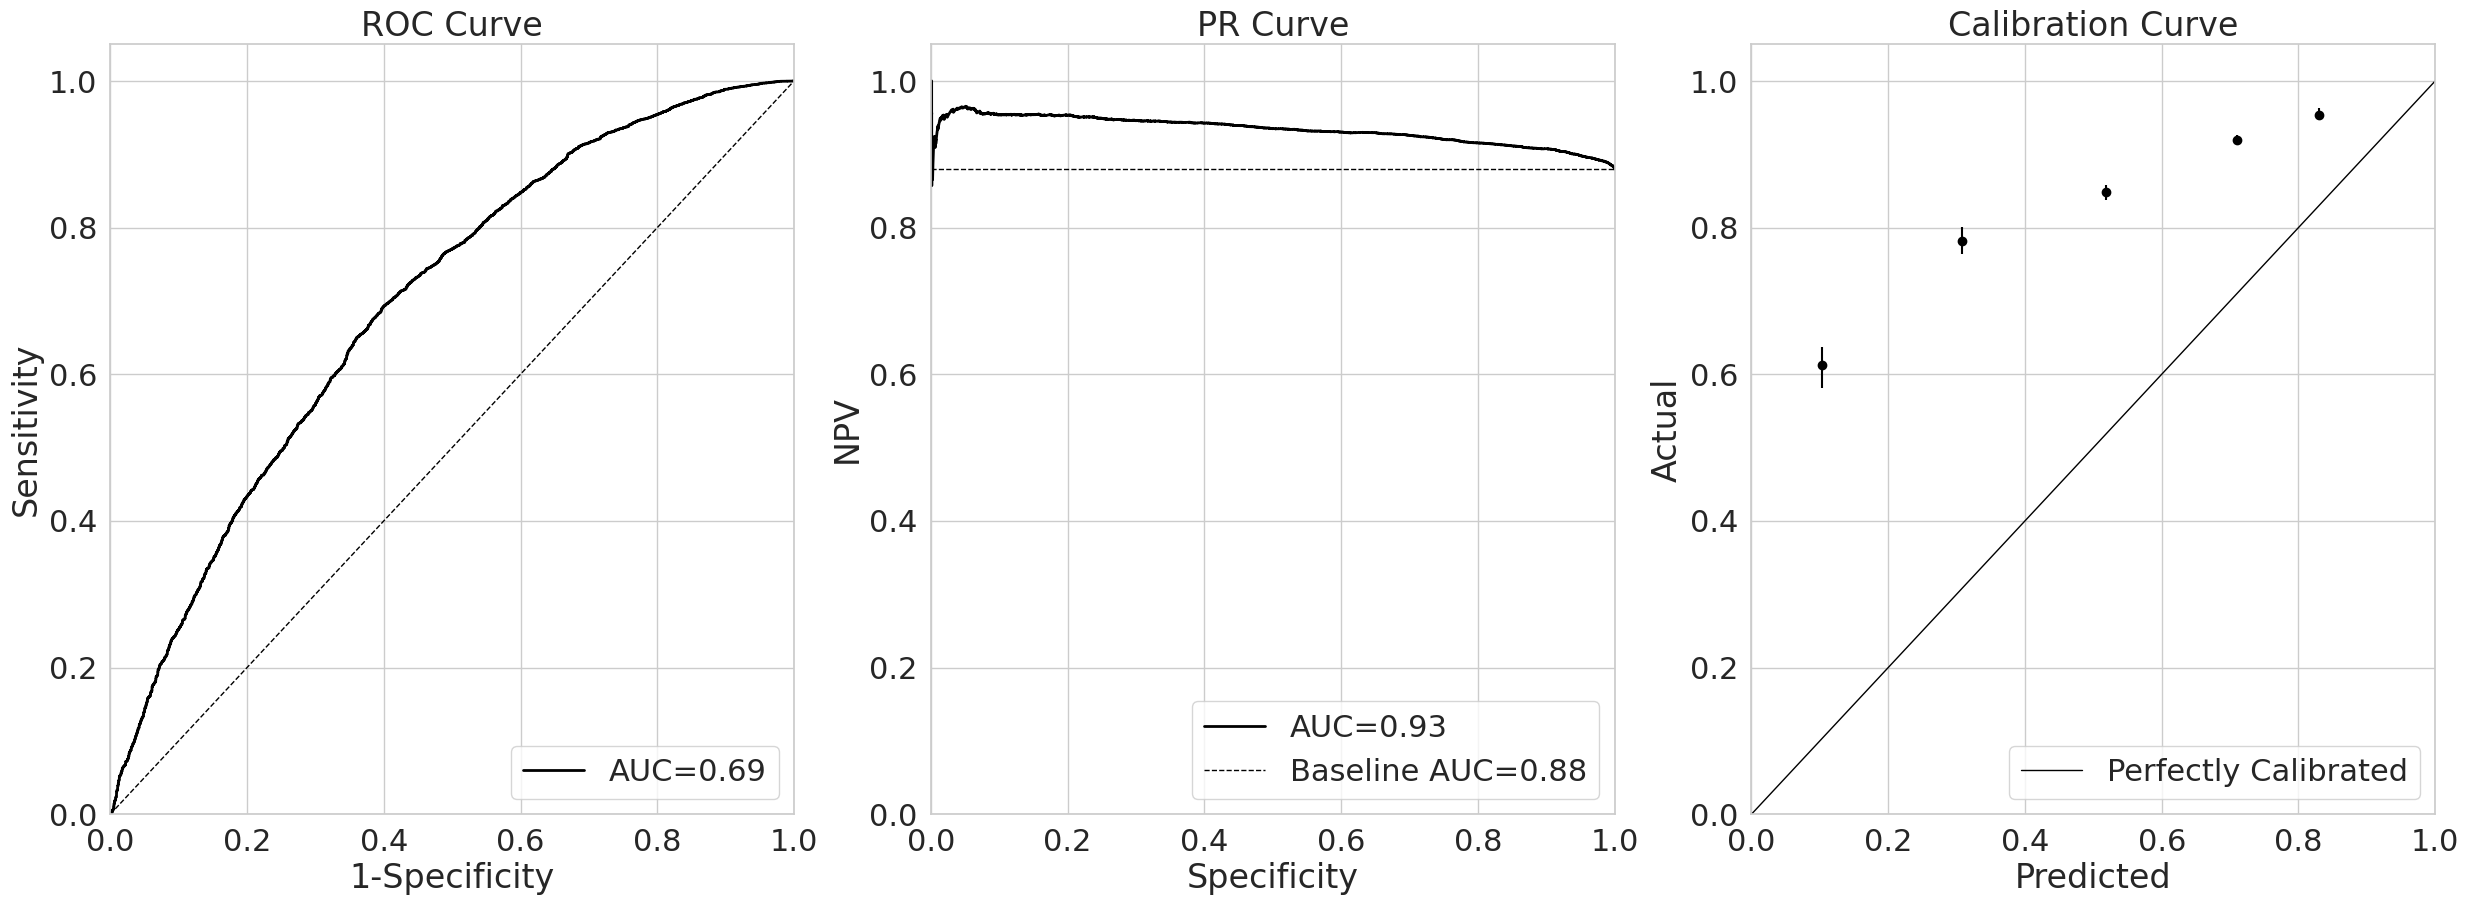

In [14]:
for task in tqdm(tasks):
    evalr = BinaryEvaluator(
        outdir="/deep/group/aihc/win23/EHR/20230218_jyx_mcp_artifacts",
        task_name=task
    )
    key = task + "_stable"
    pred = None
    if task == "label_NA":
        pred = py_hats_NA["stable_p"]
    elif task == "label_K":
        pred = py_hats_K["stable_p"]
    elif task == "label_CR":
        pred = py_hats_CR["stable_p"]
    elif task == "label_CA":
        pred = py_hats_CA["stable_p"]
    elif task == "label_ALB":
        pred = py_hats_ALB["stable_p"]
    evalr(y_test[key], pred)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [07:28<00:00, 89.75s/it]


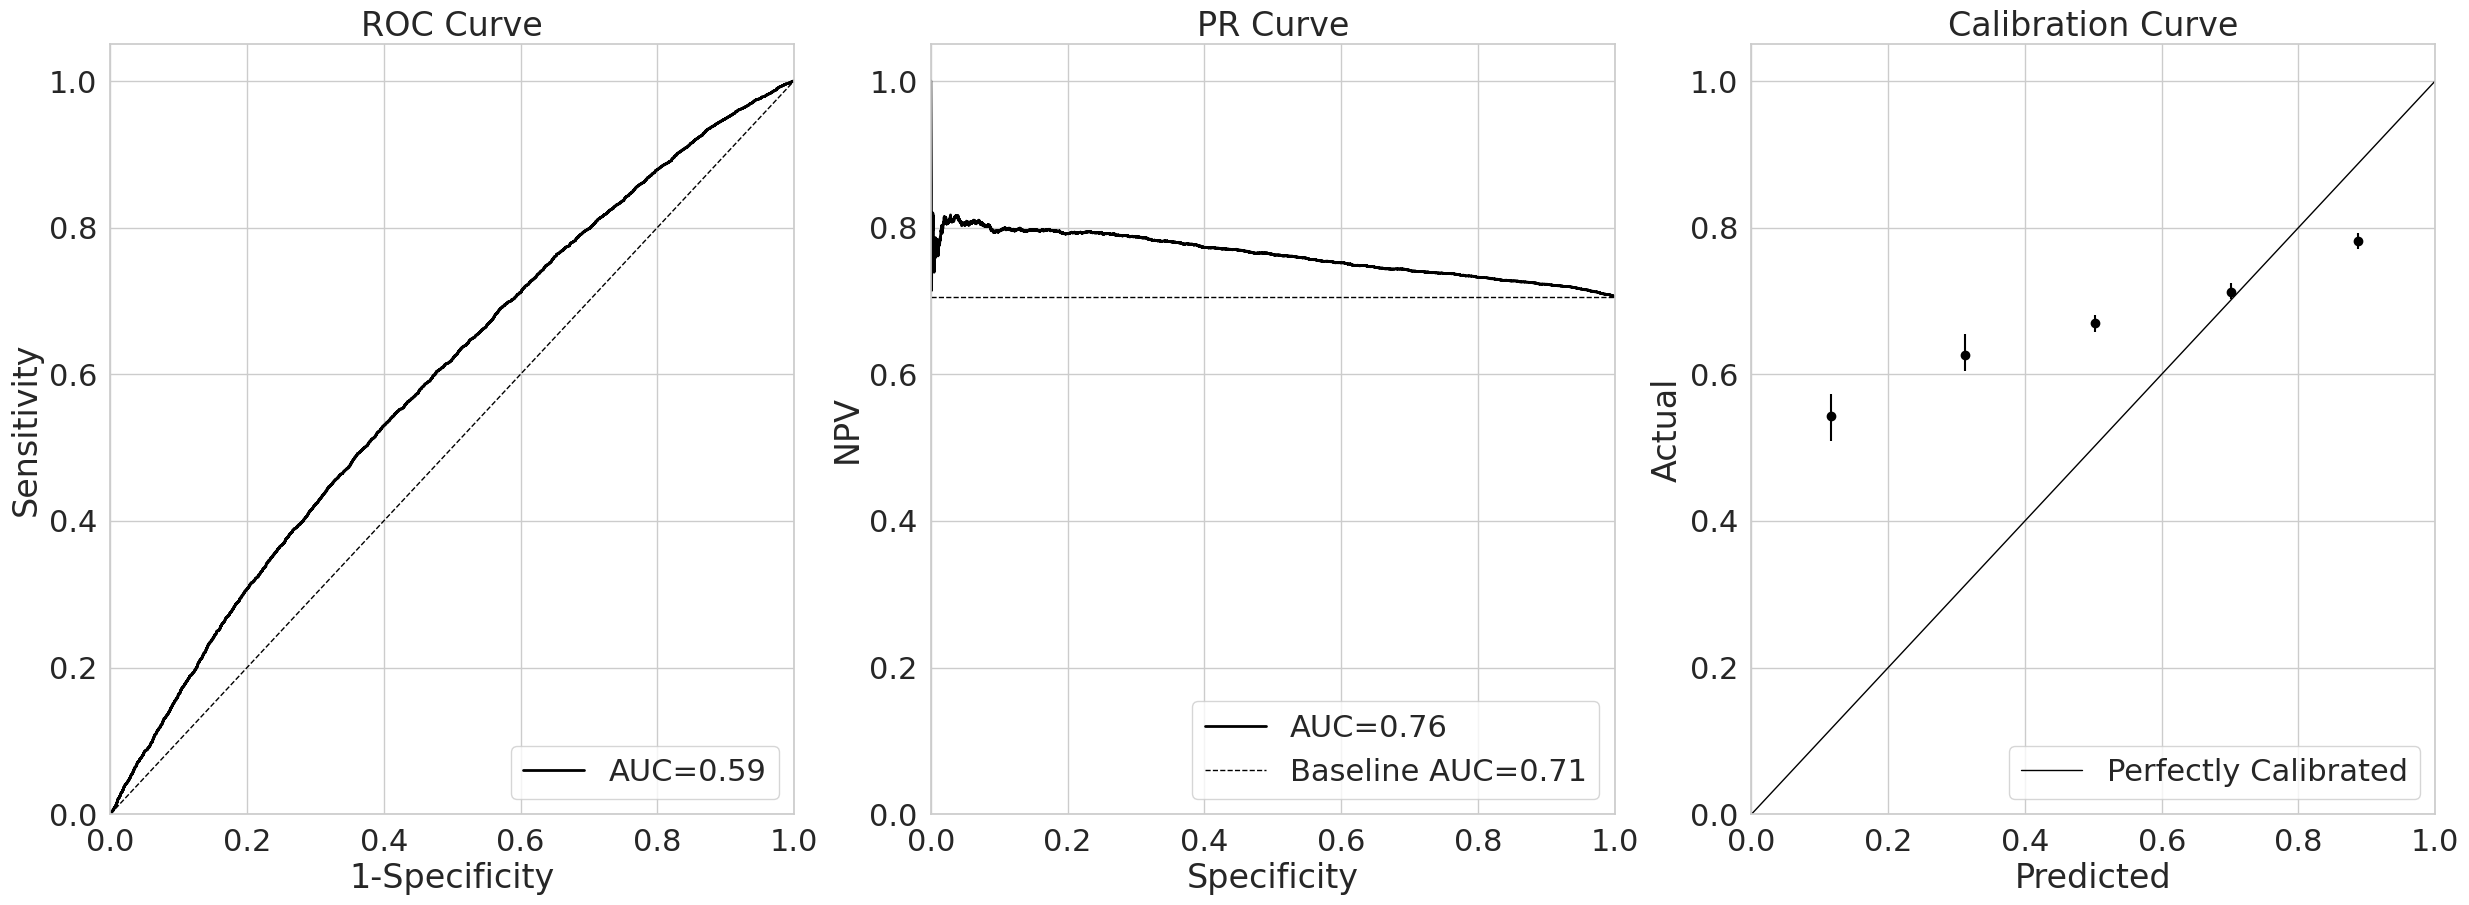

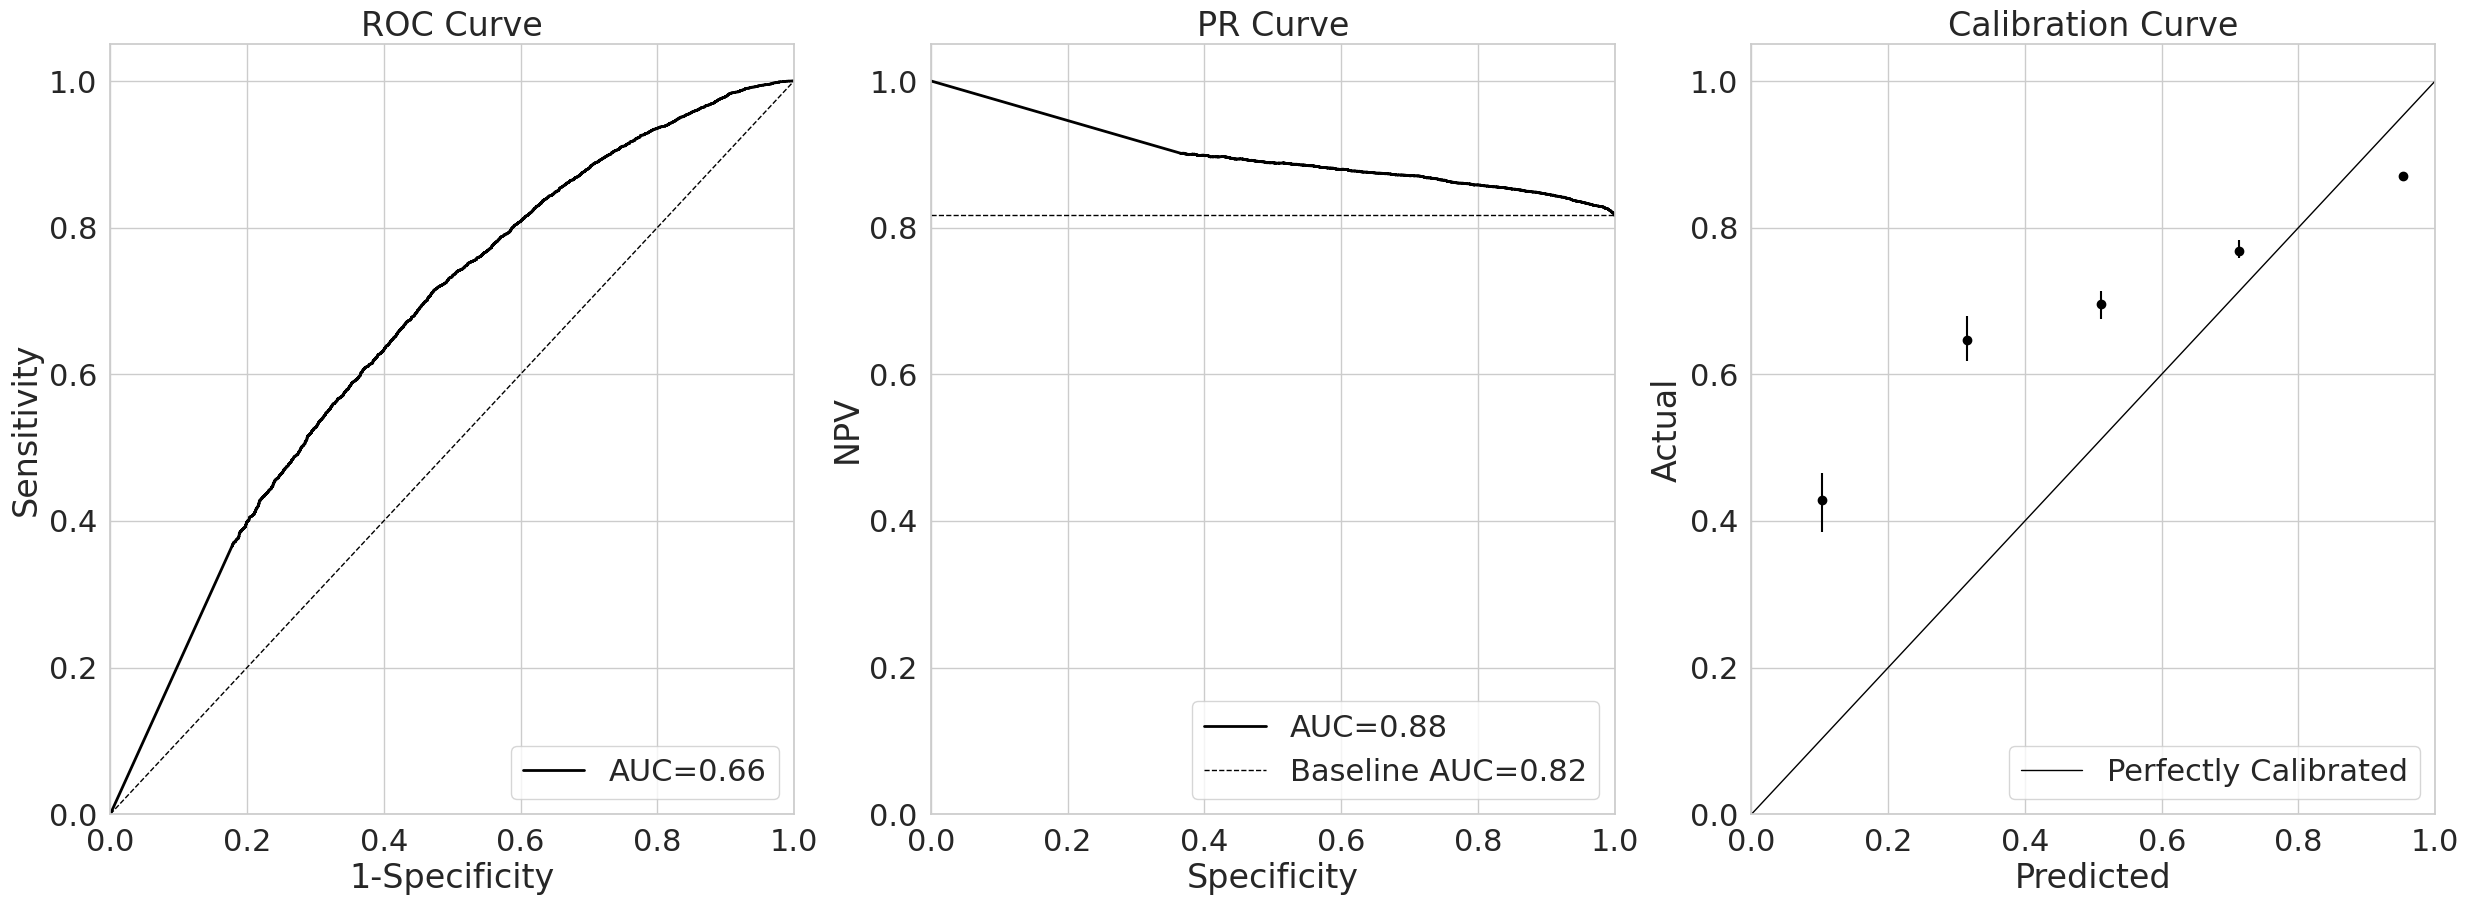

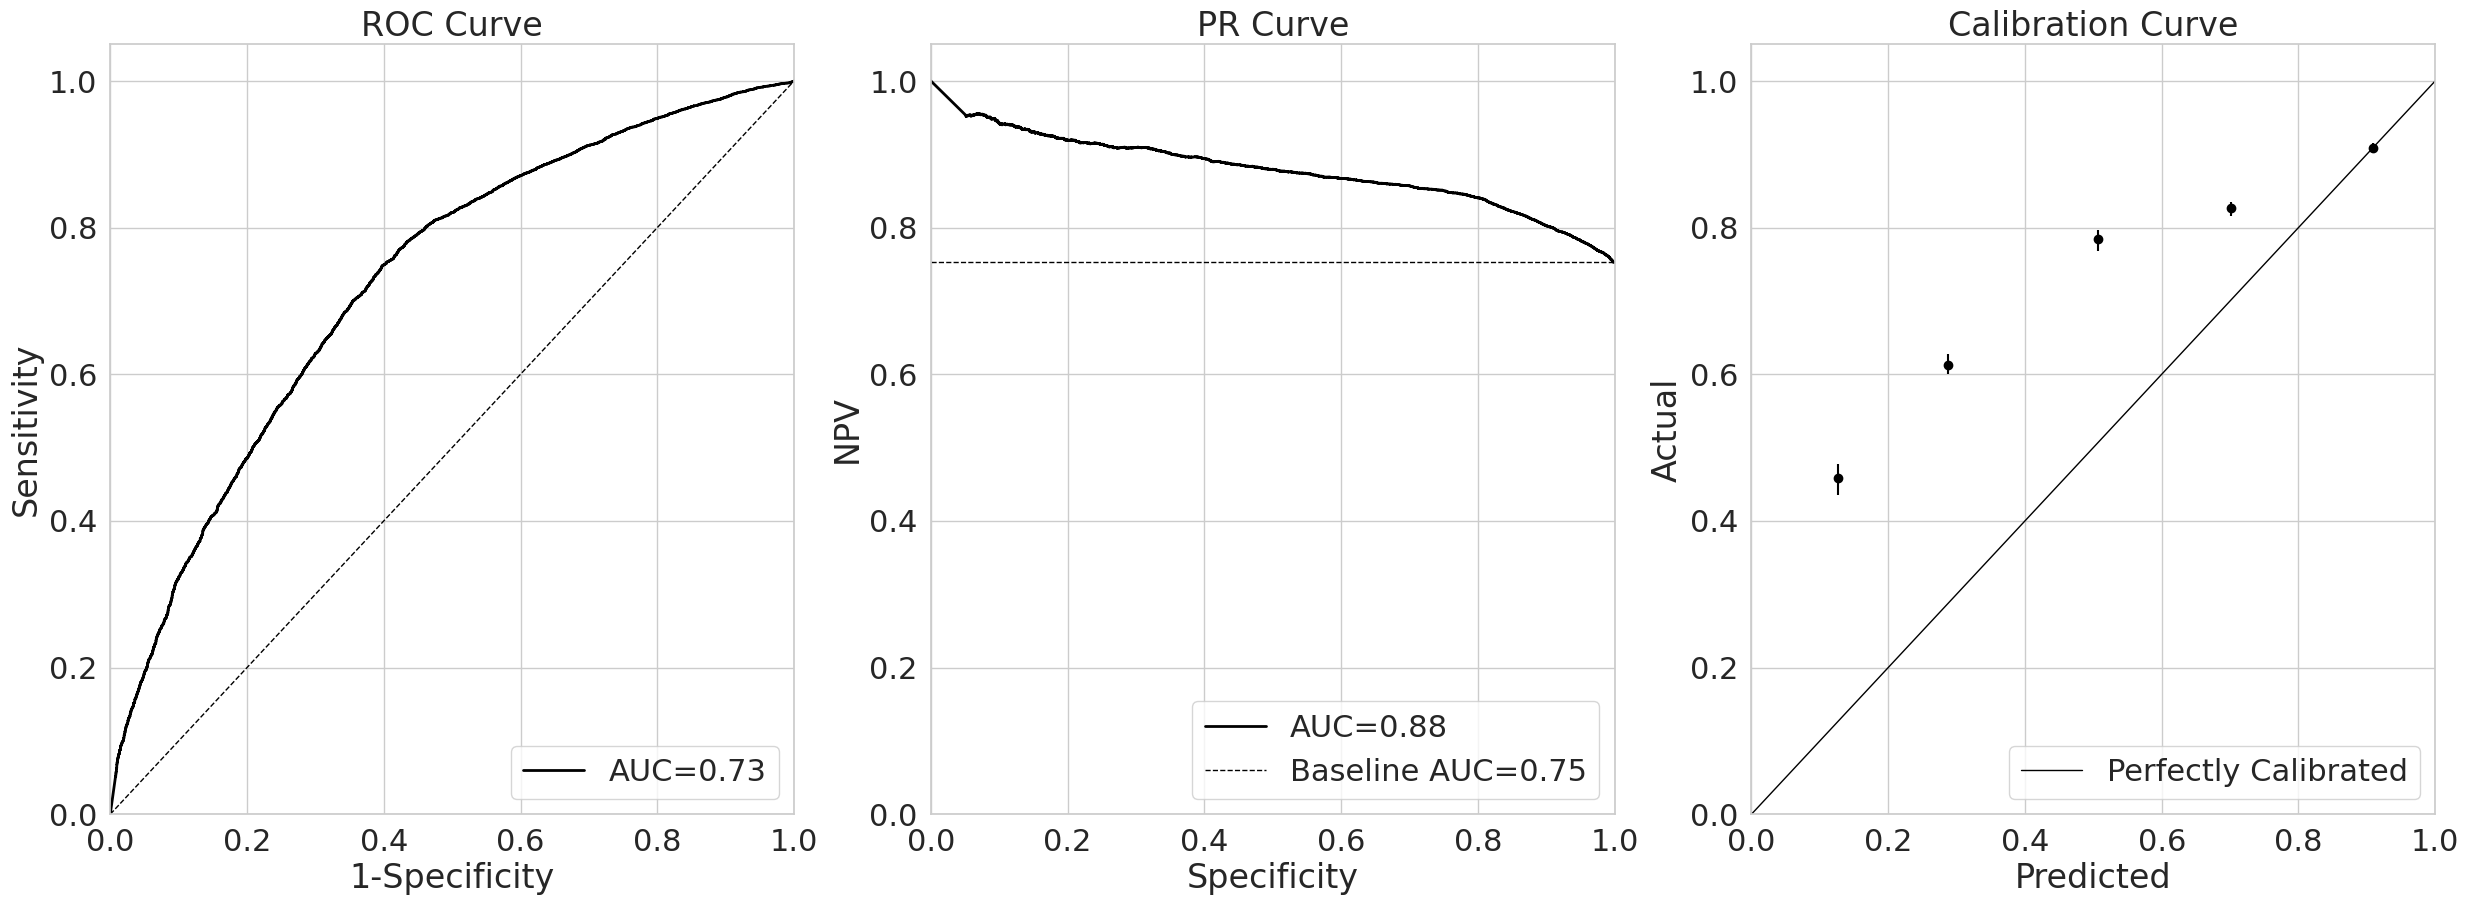

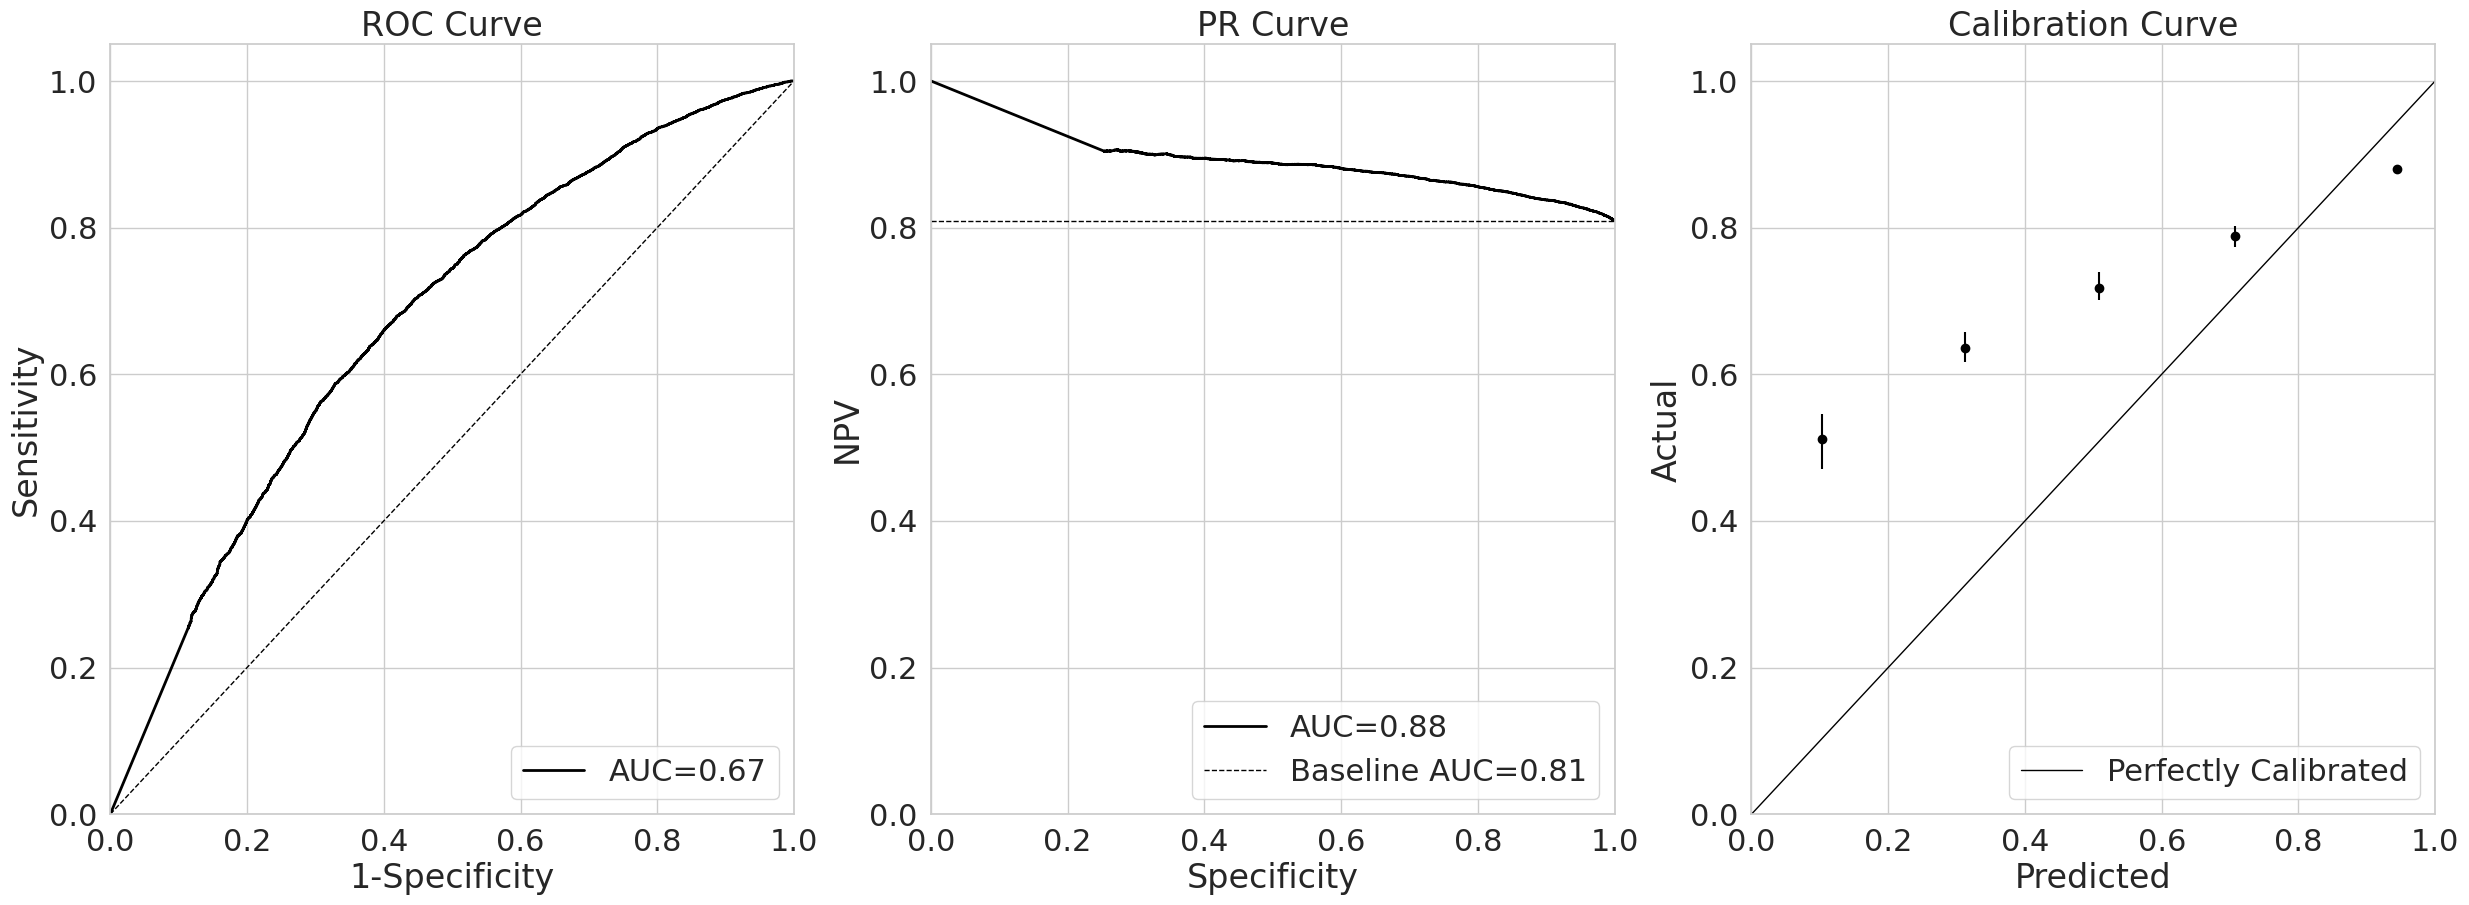

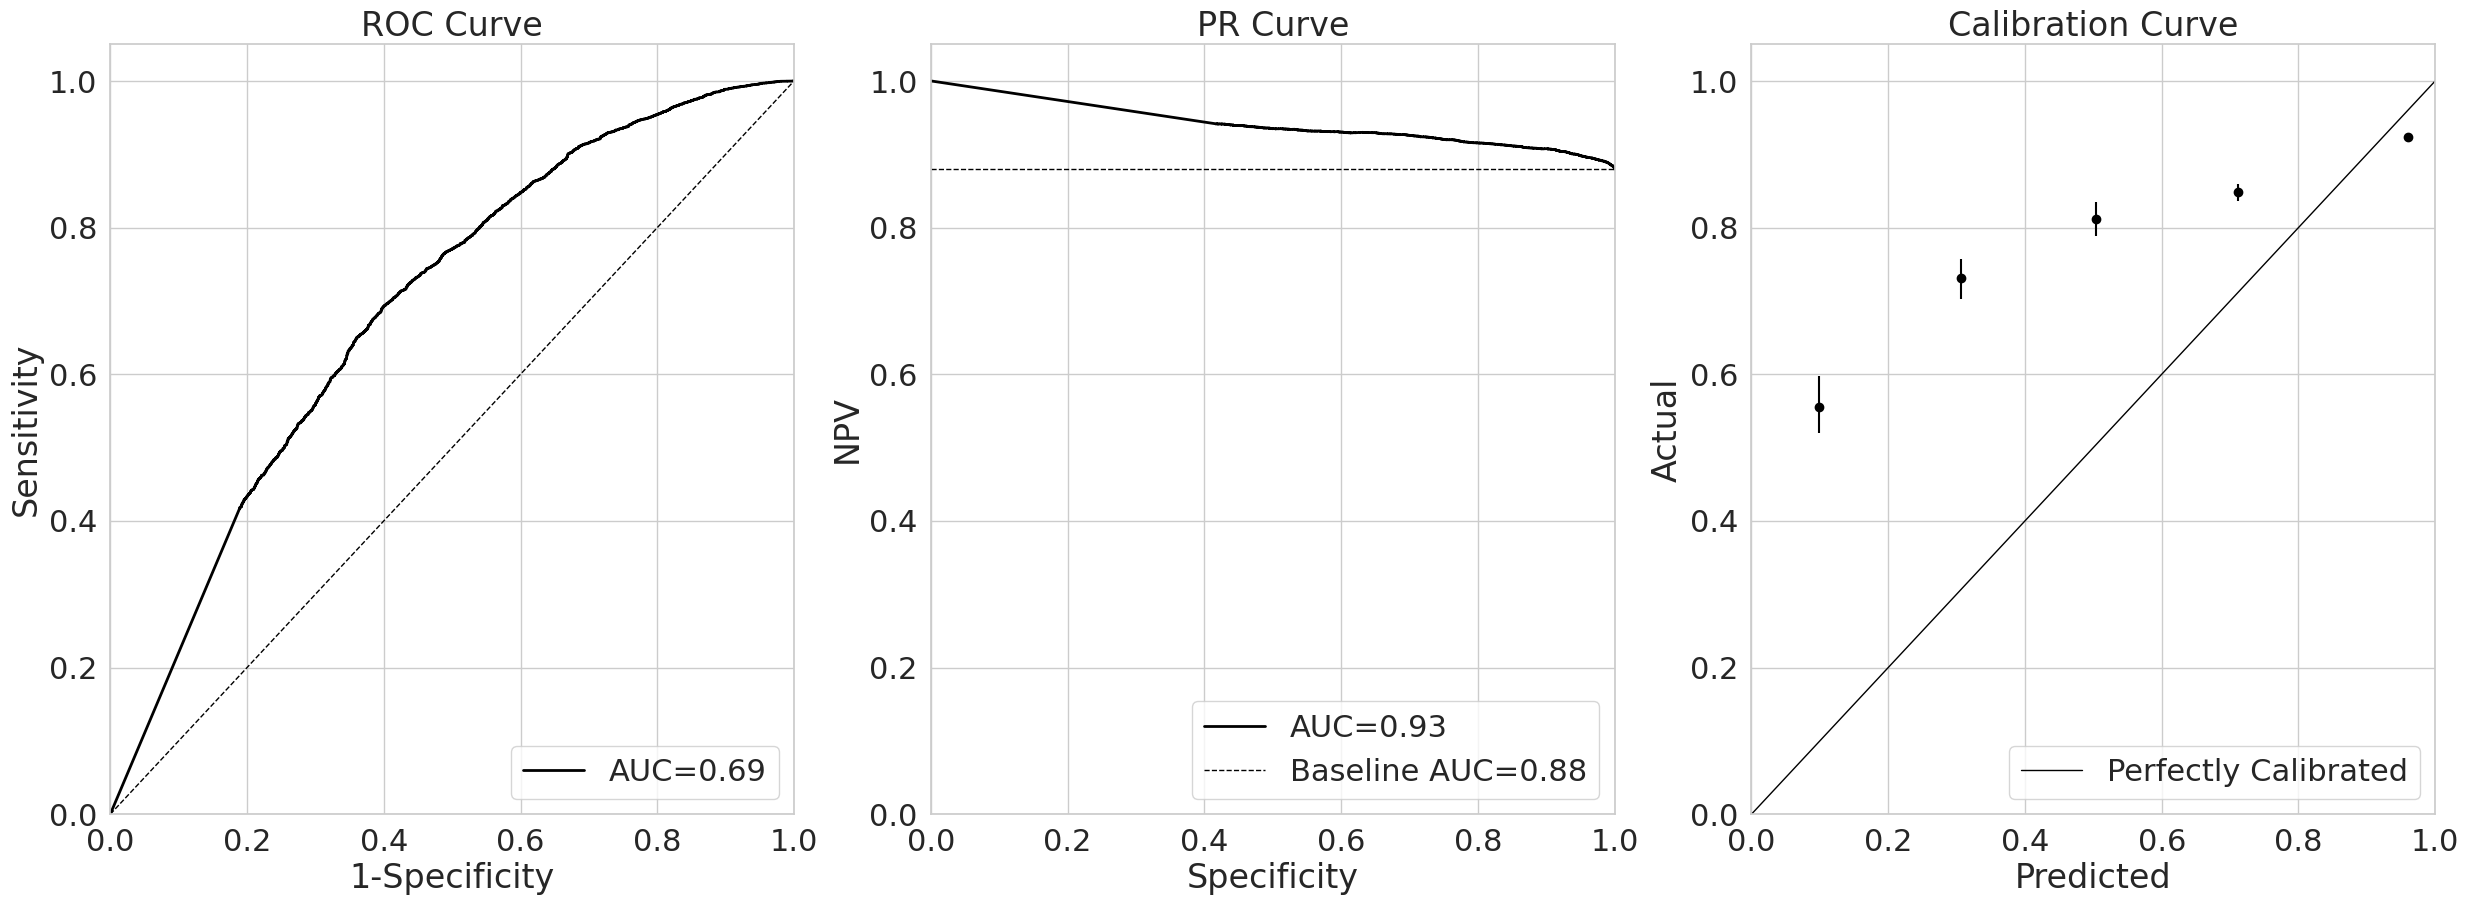

In [17]:
# With Temperature Scaling
for task in tqdm(tasks):
    evalr = BinaryEvaluator(
        outdir="/deep/group/aihc/win23/EHR/20230218_jyx_mcp_artifacts",
        task_name=task
    )
    key = task + "_stable"
    pred = None
    if task == "label_NA":
        pred = np.minimum(1, py_hats_NA["stable_p"] * 1.4)
    elif task == "label_K":
        pred = np.minimum(1, py_hats_K["stable_p"] * 1.4)
    elif task == "label_CR":
        pred = np.minimum(1, py_hats_CR["stable_p"] * 1.4)
    elif task == "label_CA":
        pred = np.minimum(1, py_hats_CA["stable_p"] * 1.4)
    elif task == "label_ALB":
        pred = np.minimum(1, py_hats_ALB["stable_p"] * 1.4)
    evalr(y_test[key], pred)